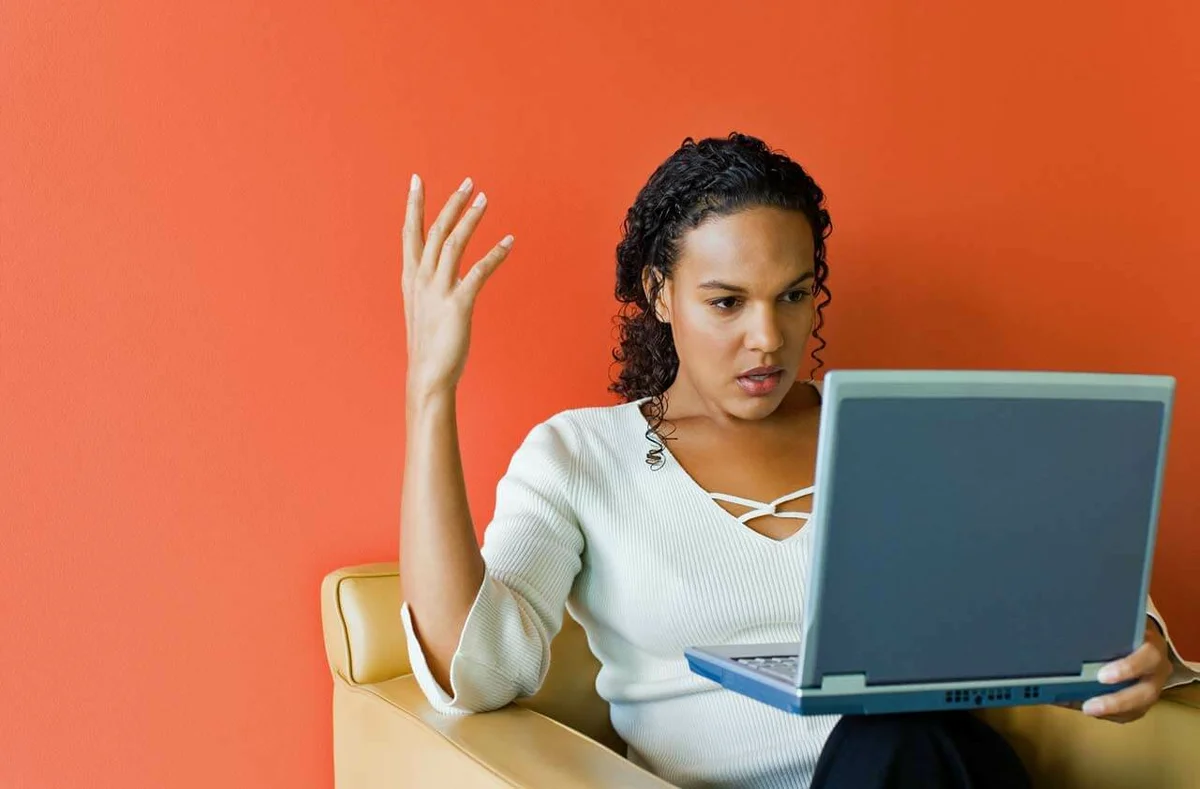

# Обучение модели классификации комментариев


# Описание проекта


Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.</br> Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.</br> 
Нужно обучить модель классифицировать комментарии на позитивные и негативные.</br> Предоставлен набор данных с разметкой о токсичности правок.

Задача - построить модель со значением метрики качества F1 не меньше 0.75. 


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#загрузка-библиотек-и-первичный-осмотр-данных" data-toc-modified-id="загрузка-библиотек-и-первичный-осмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>загрузка библиотек и первичный осмотр данных</a></span><ul class="toc-item"><li><span><a href="#баланс-классов-в-таргете" data-toc-modified-id="баланс-классов-в-таргете-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>баланс классов в таргете</a></span></li></ul></li><li><span><a href="#лемматизация-данных" data-toc-modified-id="лемматизация-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>лемматизация данных</a></span></li><li><span><a href="#проверка-на-пропуски-и-дубликаты" data-toc-modified-id="проверка-на-пропуски-и-дубликаты-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>проверка на пропуски и дубликаты</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#разбиение-выборки-на-трейн-и-тест" data-toc-modified-id="разбиение-выборки-на-трейн-и-тест-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>разбиение выборки на трейн и тест</a></span></li><li><span><a href="#stopwords" data-toc-modified-id="stopwords-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>stopwords</a></span></li><li><span><a href="#TF-IDF--+-LogisticRegression" data-toc-modified-id="TF-IDF--+-LogisticRegression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TF-IDF  + LogisticRegression</a></span></li><li><span><a href="#TF-IDF-+--DecisionTreeClassifier" data-toc-modified-id="TF-IDF-+--DecisionTreeClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>TF-IDF +  DecisionTreeClassifier</a></span></li></ul></li><li><span><a href="#Сравнение-результатов-обучения" data-toc-modified-id="Сравнение-результатов-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сравнение результатов обучения</a></span></li><li><span><a href="#Проверка-на-тесте" data-toc-modified-id="Проверка-на-тесте-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка на тесте</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка данных 

### загрузка библиотек и первичный осмотр данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LinearRegression
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import spacy
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
NJOBS = -1 # для одновременной работы всех ядер процессора при обучении моделей(для увеличения скорости) 
RANDOM = 12345
ITERATIONS = 3 #grid search iteration

Импорт рабочего датасета не показан в соответствии с политикой конфиденциальности ЯП.

In [5]:
data.head(10)  

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [6]:
data.shape

(159292, 2)

#### баланс классов в таргете

In [7]:
# частота распределения классов в таргете:

data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

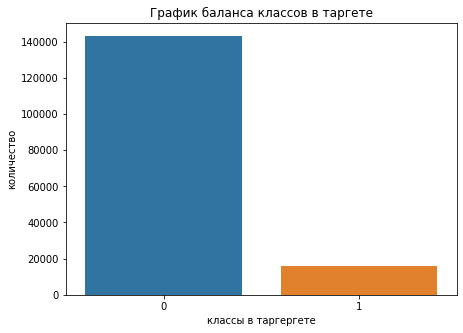

In [12]:
# график частот встречаемости классов:

plt.figure(figsize=(7,5))
sns.countplot(data=data,
              x='toxic')
plt.title('График баланса классов в таргете')
plt.xlabel('классы в таргергете', size=10)
plt.ylabel('количество', size=10);


### лемматизация данных

Воспользуемся библиотекой `SpaCy`, как более быстрой и удобной в отличие от `pymystem3`:

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [9]:
# функция для очистки текста:

def clear_text(text):
    # приводим все в нижний регистр и оставляем только латинницу:
    text = text.lower() 
    text = ' '.join(re.sub(r'[^a-z]', ' ', text).split()) 
    
    # исключаем артикли the И a:
    text = text.replace(' a ', ' ' )
    text = text.replace('a ', '')
    text = text.replace(' the ', ' ')
    text = text.replace('the ', '')
    
    # исключаем повторные пробелы и пробелы в начале и конце строк:
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [10]:
# добавим в датафрейм столбец с очищенным текстом:

data['clear'] = [clear_text(text) for text in tqdm(data['text'])]

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:05<00:00, 28295.55it/s]


In [11]:
# проверим на очистку:

data['clear'].head(5)

0    explanation why edits made under my username h...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: clear, dtype: object

In [12]:
# функция лемматизации очищенного текста"

def lemmatize(text):
    lemmatized_tokens = ' '.join([token.lemma_ for token in nlp(text)])
    return lemmatized_tokens

In [13]:
# добавим столбец с лемматизированным текстом в датафрейм:
try:
    data = pd.read_csv('data_lemm.csv')
except:
    data['lemm'] = data['clear'].apply(lemmatize)
    data.to_csv('data_lemm.csv', index=False)

data['lemm'].head(10)

0    explanation why edit make under my username ha...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
5     congratulation from I as well use tool well talk
6         cocksucker before you piss around on my work
7    your vandalism to matt shirvington article hav...
8    sorry if word nonsense be offensive to you any...
9    alignment on this subject and which be contrar...
Name: lemm, dtype: object

Для удобства дальнейшей работы, оставим в датафрейме только преобразованные столбцы и таргет:

In [14]:
data = data[['text', 'lemm', 'toxic']]

In [15]:
data.sample(10)

,text,lemm,toxic
121773,The current time is UTC,current time be utc,0
120357,Phuck?\n\nPhuck Phred Phelps.,phuck phuck phre phelp,0
137643,I agree upon two counts: edit warring (as my e...,I agree upon two count edit war as my edit be ...,0
117091,Good suggestions where the information might g...,good suggestion where information might go and...,0
5886,Air order vs viewing order \n\nWith the DVD co...,air order vs view order with dvd collection I ...,0
12858,you are a manipulator.,you be manipulator,0
121256,"""\n\n No original research! \n\n Please read W...",no original research please read wp primary an...,0
58821,"Actually, I just moved it as well. No problem.",actually I just move it as well no problem,0
122719,"2007 (UTC)\nAs a Ron Paul supporter, I affirm ...",utc as ron paul supporter I affirm what above ...,0
127273,Vandalism by the IP also noted.,vandalism by ip also note,0


### проверка на пропуски и дубликаты 

In [16]:
# явные дубликаты:
data.duplicated().sum()
data = data.drop_duplicates()

In [17]:
# пропуски:
print(data.isna().sum())
data = data.dropna()

text      0
lemm     11
toxic     0
dtype: int64


**Вывод**:
- загружены библиотеки для работы и сами данные.
- исследован баланс классов в таргете.
- текст очищен и лемматизирован.
- данные проверены не явные дубликаты и пропуски.
- в выборке оставлены только нужные для дальнейшей работы столбцы.
    

## Обучение моделей

### разбиение выборки на трейн и тест

In [18]:
train, test = train_test_split(data, test_size=0.25, random_state = RANDOM)
print(train.shape, test.shape)

(119460, 3) (39821, 3)


In [19]:
# выделим рабочие и таргетные столбцы для выборок:

X_train = train['lemm']
y_train = train['toxic']

X_test = test['lemm']
y_test = test['toxic']



Во избежание утечки данных, векторизация должная учиться на трейне, а применяться ко всему, поэтому будем использовать Pipeline


### stopwords

In [20]:
# загрузим фильтр стоп-слов:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### TF-IDF  + LogisticRegression

In [21]:
pipe_lg = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logisticregression', LogisticRegression(random_state=RANDOM,
                                              class_weight='balanced',
                                              max_iter=50,
                                              n_jobs=-1))
    ])

param_lg = {
    'logisticregression__C': range(1, 10, 2),
    'tfidf__max_features': [100000],
    'tfidf__ngram_range': [(1, 1)]
}


In [22]:
rs_lg = RandomizedSearchCV(
    pipe_lg, 
    param_distributions=param_lg, 
    scoring='f1',
    cv=3,
    n_iter=ITERATIONS,
    verbose=3,
    random_state=RANDOM
)

In [23]:
%%time
rs_lg.fit(X_train, y_train)
print(f'''Лучшие гиперпараметры модели LogisticRegression+TF-IDF: {rs_lg.best_params_},
Лучшая метрика f1 модели LogisticRegression+TF-IDF: {rs_lg.best_score_}''')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END logisticregression__C=1, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.741 total time=   5.6s
[CV 2/3] END logisticregression__C=1, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.746 total time=   5.0s
[CV 3/3] END logisticregression__C=1, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.751 total time=   4.9s
[CV 1/3] END logisticregression__C=9, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.760 total time=   4.9s
[CV 2/3] END logisticregression__C=9, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.762 total time=   4.9s
[CV 3/3] END logisticregression__C=9, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.761 total time=   5.0s
[CV 1/3] END logisticregression__C=7, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.756 total time=   4.8s
[CV 2/3] END logisticregression__C=7, tfidf__max_features=100000, 

### TF-IDF +  DecisionTreeClassifier

In [24]:
# создадим пайплайн с признаками TF-IDF:
dtr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('dtr', DecisionTreeClassifier(random_state=RANDOM, class_weight='balanced'))
])


In [25]:
# сетка параметров для поиска наилучших:

param_grid = {
    'tfidf__max_features': [100000],
    'tfidf__ngram_range': [(1, 1)],
    'dtr__max_depth': [5, 10],
}

In [26]:
# использование RandomizedSearchCV для поиска по сетке:

dtr_rs = RandomizedSearchCV(dtr_pipe,
                           param_distributions=param_grid,
                           scoring='f1',
                           cv=3,
                           n_iter=ITERATIONS,
                           random_state=RANDOM,
                           verbose=3)

In [27]:
%%time
dtr_rs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END dtr__max_depth=5, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.424 total time=   5.6s
[CV 2/3] END dtr__max_depth=5, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.435 total time=   5.4s
[CV 3/3] END dtr__max_depth=5, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.439 total time=   5.5s
[CV 1/3] END dtr__max_depth=10, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.553 total time=   8.0s
[CV 2/3] END dtr__max_depth=10, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.565 total time=   8.0s
[CV 3/3] END dtr__max_depth=10, tfidf__max_features=100000, tfidf__ngram_range=(1, 1);, score=0.575 total time=   7.9s
CPU times: total: 50.8 s
Wall time: 50.5 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('dtr',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=12345))]),
                   n_iter=3,
                   param_distributions={'dtr__max_depth': [5, 10],
                                        'tfidf__max_features': [100000],
                                        'tfidf__ngram_range': [(1, 1)]},
                   random_state=12345, scoring='f1', verbose=3)

In [28]:
dtr_rs.best_params_

{'tfidf__ngram_range': (1, 1),
 'tfidf__max_features': 100000,
 'dtr__max_depth': 10}

In [29]:
dtr_rs.best_score_

0.5642055586020315

In [30]:
print(f'Метрика F1 для кросс-валидации TF-IDF + DecisionTreeClassifier', dtr_rs.best_score_)

Метрика F1 для кросс-валидации TF-IDF + DecisionTreeClassifier 0.5642055586020315


## Сравнение результатов обучения

In [32]:
# приведем результаты в общую таблицу:

result = pd.DataFrame({'F1-score' : [dtr_rs.best_score_, rs_lg.best_score_]},
                                     index=['TF-IDF+DTC', 'TF-IDF+LR'])
result

,F1-score
TF-IDF+DTC,0.564206
TF-IDF+LR,0.760966


**Вывод:**
- в результате обучения, лучшей моделью оказалась LogisticRegression с F1-score=0.76

## Проверка на тесте


In [36]:
# предсказание на тестовой выборке
pred = rs_lg.predict(X_test)

In [37]:
f1_score = f1_score(y_test, pred)
f1_score

0.752533879968113

**Вывод**:
 - лучшая модель Логистической Регресии прошла проверку на тестовой выборке с результатом F1-score = 0.7525

## Общий вывод

В результате работы над проектом выполнено следующее:
 - Рабочий датасет загружен и прлверен на пропуски и нулевые значения.
 - Исследован балланс классов в таргете.
 - Проведена лемматизация данных.
 - Данные разбиты на трейновую и тестовую выборки.
 - Твиты очищены от стоп-слов.
 - Применена TF-IDF + LogisticRegression и TF-IDF + DecisionTreeClassifier
 - В результате требованию по F1-score >= 0.75 соответствовала модель Логистичесской регрессии.
 - Также лучшая модель Логистичесской регрессии была проверена на тесте с F1-score = 0.752.